👕👖👗👟 Fashion MNIST Clothing Generator 👕👖👗👟

In this notebook, we will use the Fashion MNIST dataset to train a generative model that can generate new clothing items. The Fashion MNIST dataset consists of 60,000 grayscale images of 10 different clothing categories, such as T-shirts, trousers, dresses, and shoes.

🔧📊 **Tools and Techniques** 🔧📊

- Keras: We will use the Keras library, a high-level neural networks API, to build and train our generative model.
- Convolutional Neural Networks (CNNs): We will utilize CNNs, a type of deep learning model, to learn the patterns and features of the clothing items in the dataset.
- Generative Adversarial Networks (GANs): We will employ GANs, a framework consisting of a generator and a discriminator, to generate new clothing items that resemble the ones in the dataset.

📚 **Steps** 📚

1. **Data Preparation**: We will load and preprocess the Fashion MNIST dataset, including normalizing the pixel values and splitting it into training and testing sets.
2. **Model Architecture**: We will define the architecture of our generative model, which consists of a generator network and a discriminator network.
3. **Training**: We will train our generative model using the Fashion MNIST dataset, optimizing the generator and discriminator networks through an adversarial training process.
4. **Generation**: Once the model is trained, we will use the generator network to generate new clothing items by sampling from the learned distribution of the latent space.
5. **Evaluation**: We will evaluate the quality of the generated clothing items using various metrics, such as visual inspection and comparison with real clothing items from the dataset.

🌟 **Expected Outcome** 🌟

By the end of this notebook, you will have a trained generative model that can generate new clothing items that resemble the ones in the Fashion MNIST dataset. You can use this model to explore and generate unique clothing designs or even assist in the fashion industry for generating new ideas.

Let's get started and unleash our creativity with the Fashion MNIST Clothing Generator! 🎨👚👖👗👟


In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
from keras.datasets import fashion_mnist

(x_train, train_labels), (x_test, test_labels) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)


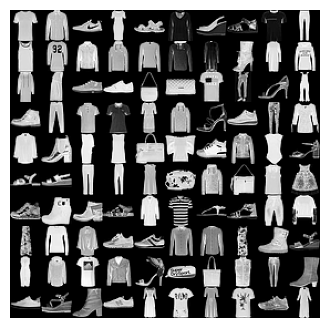

In [2]:
import random
import matplotlib.pyplot as plt
# Define the grid size
grid_size = (10, 10)

# Select random images from the dataset
random_images = random.choices(x_train, k=grid_size[0]*grid_size[1])

# Create subplots
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(4, 4))

# Plot the images
for i, ax in enumerate(axes.flat):
    ax.imshow(random_images[i], cmap='gray')
    ax.axis('off')

# Set padding between the images
plt.subplots_adjust(hspace=0, wspace=0)

# Show the plot
plt.show()


In [3]:
import keras
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Lambda, Conv2DTranspose
from keras import backend as K

# Define the input shape
input_shape = (28, 28, 1)
latent_dim = 128

# Encoder
encoder_inputs = keras.Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Latent space
flatten = Flatten()(encoded)
z_mean = Dense(latent_dim)(flatten)
z_log_var = Dense(latent_dim)(flatten)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_inputs =Input(shape=(latent_dim))
x = Dense(7 * 7 * 8, activation='relu')(decoder_inputs)
x = Reshape((7, 7, 8))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoder_outputs = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

# Variational Autoencoder
encoder = keras.Model(encoder_inputs, z, name='encoder')
decoder = keras.Model(decoder_inputs, decoder_outputs, name='decoder')
vae_outputs = decoder(encoder(encoder_inputs))
vae = keras.Model(encoder_inputs, vae_outputs, name='vae')

# Loss function
def vae_loss(inputs, outputs):
    reconstruction_loss = keras.losses.binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
    reconstruction_loss *= input_shape[0] * input_shape[1]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()


Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 128)               10936     
                                                                 
 decoder (Functional)        (None, 60, 60, 1)         53049     
                                                                 
Total params: 63,985
Trainable params: 63,985
Non-trainable params: 0
_________________________________________________________________


In [4]:
import tensorflow as tf
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

vae.fit(x_train, x_train, epochs=10, batch_size=128)

Train on 60000 samples
Epoch 1/10


2024-02-02 12:51:15.147862: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-02 12:51:15.173886: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/dense_1/bias/v/Assign' id:1123 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/bias/v, training/Adam/dense_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


InvalidArgumentError: Incompatible shapes: [100352] vs. [460800]
	 [[{{node training/Adam/gradients/gradients/loss/decoder_loss/mul_grad/BroadcastGradientArgs}}]]

In [36]:
z_mean,z_log_var,z = encoder.predict(x_test)
decoded = decoder.predict(z)
#calculate the loss
loss = vae.evaluate(x_test, x_test, verbose=0)

/Users/helgesorenstein/mambaforge/lib/python3.10/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-02-02 12:47:41.540458: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_4/mul' id:2851 op device:{requested: '', assigned: ''} def:{{{node loss_4/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_4/mul/x, loss_4/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


InvalidArgumentError: Incompatible shapes: [115200] vs. [25088]
	 [[{{node loss_4/decoder_loss/mul}}]]

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convert the labels to one-hot encoding
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Define the model architecture
model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


Train on 54000 samples, validate on 6000 samples
Epoch 1/10
16640/54000 [========>.....................] - ETA: 0s - loss: 0.7533 - accuracy: 0.7448

2024-02-02 12:51:50.188031: W tensorflow/c/c_api.cc:291] Operation '{name:'training_2/Adam/dense_3/kernel/v/Assign' id:1560 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_3/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_3/kernel/v, training_2/Adam/dense_3/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


54000/54000 [==============================] - 0s 8us/sample - loss: 0.5687 - accuracy: 0.8054 - val_loss: 0.4599 - val_accuracy: 0.8365
Epoch 2/10
15744/54000 [=======>......................] - ETA: 0s - loss: 0.4315 - accuracy: 0.8506

/Users/helgesorenstein/mambaforge/lib/python3.10/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-02-02 12:51:50.594990: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:1450 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_4_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


54000/54000 [==============================] - 0s 7us/sample - loss: 0.4165 - accuracy: 0.8530 - val_loss: 0.3918 - val_accuracy: 0.8603
Epoch 3/10
54000/54000 [==============================] - 0s 7us/sample - loss: 0.3747 - accuracy: 0.8684 - val_loss: 0.3694 - val_accuracy: 0.8695
Epoch 4/10
54000/54000 [==============================] - 0s 7us/sample - loss: 0.3459 - accuracy: 0.8764 - val_loss: 0.3470 - val_accuracy: 0.8750
Epoch 5/10
54000/54000 [==============================] - 0s 7us/sample - loss: 0.3262 - accuracy: 0.8830 - val_loss: 0.3398 - val_accuracy: 0.8757
Epoch 6/10
54000/54000 [==============================] - 0s 7us/sample - loss: 0.3101 - accuracy: 0.8881 - val_loss: 0.3606 - val_accuracy: 0.8673
Epoch 7/10
54000/54000 [==============================] - 0s 7us/sample - loss: 0.2970 - accuracy: 0.8933 - val_loss: 0.3400 - val_accuracy: 0.8803
Epoch 8/10
54000/54000 [==============================] - 0s 7us/sample - loss: 0.2872 - accuracy: 0.8942 - val_loss: 0.333

/Users/helgesorenstein/mambaforge/lib/python3.10/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-02-02 12:53:05.003403: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_4/Softmax' id:1374 op device:{requested: '', assigned: ''} def:{{{node dense_4/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_4/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


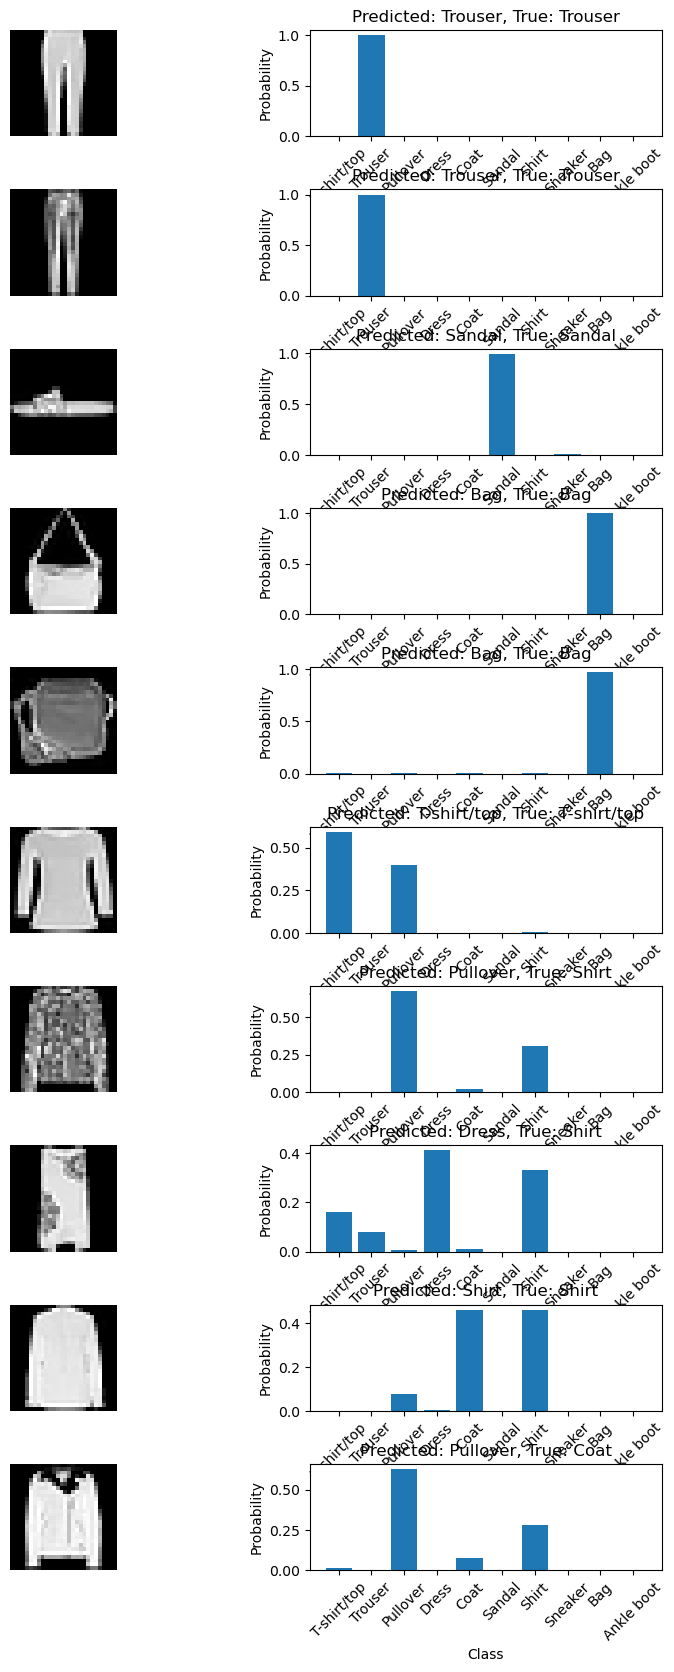

In [6]:
import numpy as np

# Define the class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Select random images from the test set
random_indices = np.random.choice(len(x_test), size=10, replace=False)
images = x_test[random_indices]
labels = y_test[random_indices]

# Make predictions using the trained model
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Create subplots
fig, axes = plt.subplots(10, 2, figsize=(10, 20))

# Plot the images and predictions
for i, ax in enumerate(axes):
    # Plot the image
    ax[0].imshow(images[i], cmap='gray')
    ax[0].axis('off')
    
    # Plot the barplot with predictions
    ax[1].bar(range(num_classes), predictions[i])
    ax[1].set_xticks(range(num_classes))
    ax[1].set_xticklabels(class_names, rotation=45)
    ax[1].set_xlabel('Class')
    ax[1].set_ylabel('Probability')
    ax[1].set_title(f'Predicted: {class_names[predicted_labels[i]]}, True: {class_names[np.argmax(labels[i])]}')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add a channel dimension to the data
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Define the model architecture
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


Train on 54000 samples, validate on 6000 samples
Epoch 1/10
  768/54000 [..............................] - ETA: 7s - loss: 2.1323 - accuracy: 0.3464 

2024-02-02 12:54:55.161799: W tensorflow/c/c_api.cc:291] Operation '{name:'training_4/Adam/iter/Assign' id:1868 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_4/Adam/iter, training_4/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


53760/54000 [============================>.] - ETA: 0s - loss: 0.5673 - accuracy: 0.7950

2024-02-02 12:54:59.829442: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_2/mul' id:1802 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/dense_6_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


54000/54000 [==============================] - 5s 89us/sample - loss: 0.5667 - accuracy: 0.7951 - val_loss: 0.4005 - val_accuracy: 0.8537
Epoch 2/10
54000/54000 [==============================] - 5s 89us/sample - loss: 0.3612 - accuracy: 0.8716 - val_loss: 0.3414 - val_accuracy: 0.8753
Epoch 3/10
54000/54000 [==============================] - 5s 88us/sample - loss: 0.3104 - accuracy: 0.8871 - val_loss: 0.3299 - val_accuracy: 0.8797
Epoch 4/10
54000/54000 [==============================] - 5s 89us/sample - loss: 0.2831 - accuracy: 0.8964 - val_loss: 0.2895 - val_accuracy: 0.8950
Epoch 5/10
54000/54000 [==============================] - 5s 89us/sample - loss: 0.2601 - accuracy: 0.9051 - val_loss: 0.2943 - val_accuracy: 0.8875
Epoch 6/10
54000/54000 [==============================] - 5s 90us/sample - loss: 0.2406 - accuracy: 0.9103 - val_loss: 0.2649 - val_accuracy: 0.9052
Epoch 7/10
54000/54000 [==============================] - 5s 89us/sample - loss: 0.2204 - accuracy: 0.9182 - val_loss

2024-02-02 12:55:59.113744: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_6/Softmax' id:1744 op device:{requested: '', assigned: ''} def:{{{node dense_6/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_6/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


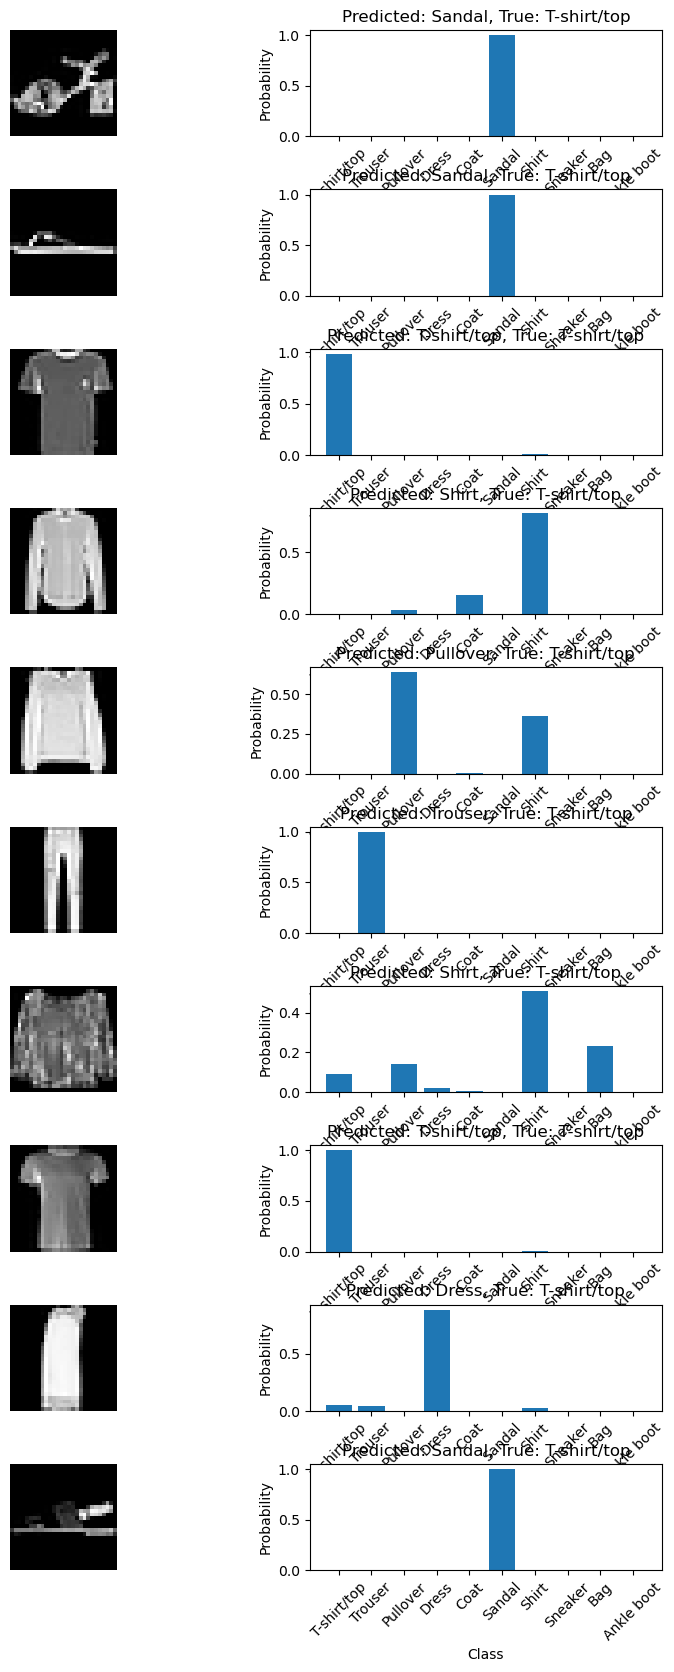

In [9]:
import numpy as np

# Define the class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Select random images from the test set
random_indices = np.random.choice(len(x_test), size=10, replace=False)
images = x_test[random_indices]
labels = y_test[random_indices]

# Make predictions using the trained model
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Create subplots
fig, axes = plt.subplots(10, 2, figsize=(10, 20))

# Plot the images and predictions
for i, ax in enumerate(axes):
    # Plot the image
    ax[0].imshow(images[i], cmap='gray')
    ax[0].axis('off')
    
    # Plot the barplot with predictions
    ax[1].bar(range(num_classes), predictions[i])
    ax[1].set_xticks(range(num_classes))
    ax[1].set_xticklabels(class_names, rotation=45)
    ax[1].set_xlabel('Class')
    ax[1].set_ylabel('Probability')
    ax[1].set_title(f'Predicted: {class_names[predicted_labels[i]]}, True: {class_names[np.argmax(labels[i])]}')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()


In [10]:
import shap

# Load the SHAP explainer
explainer = shap.Explainer(model)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [22]:

# Select a random image from the test set
random_index = np.random.choice(len(x_test))
image = x_test[0,:,:,:]

In [23]:

# Calculate the SHAP values for the image
shap_values = explainer.shap_values(image)

# Plot the SHAP values
shap.image_plot(shap_values, -image)


TypeError: 'NoneType' object is not callable